In [35]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install scikit-learn
!python -m pip install umap-learn

In [21]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

INPUT_CSV = "synthetic_patients.csv"
OUT_DIR = "clients_data"  # will create one csv per superpopulation
SUPERPOP_COL = "superpopulation"

## Data prep (split by ancestry clients, assuming data was collected by a separate client)

In [22]:
df = pd.read_csv(INPUT_CSV)

os.makedirs(OUT_DIR, exist_ok=True)
for sp, g in df.groupby(SUPERPOP_COL):
    out = os.path.join(OUT_DIR, f"client_{sp}.csv")
    g.to_csv(out, index=False)
    print("wrote", out, "rows", len(g))

wrote clients_data/client_AFR.csv rows 3000
wrote clients_data/client_AMR.csv rows 3000
wrote clients_data/client_EAS.csv rows 3000
wrote clients_data/client_EUR.csv rows 3000
wrote clients_data/client_SAS.csv rows 3000


# NVFlare

In [23]:
!python -m pip install nvflare=="2.7.1"

In [ ]:
!python "main_kmeans.py" --k 5 --num_rounds 30 --seed 2026 --workspace output_nvflare_kmeans

2026-01-09 22:57:09,750 - INFO - Initializing ScatterAndGather workflow for Federated Averaging.
2026-01-09 22:57:09,751 - INFO - Beginning ScatterAndGather training phase.
2026-01-09 22:57:09,752 - INFO - Round 0 started.
2026-01-09 22:57:13,559 - INFO - Contribution from AMR ACCEPTED by the aggregator at round 0.
2026-01-09 22:57:13,582 - INFO - Contribution from EUR ACCEPTED by the aggregator at round 0.
2026-01-09 22:57:13,600 - INFO - Contribution from AFR ACCEPTED by the aggregator at round 0.
2026-01-09 22:57:13,618 - INFO - Contribution from SAS ACCEPTED by the aggregator at round 0.
2026-01-09 22:57:13,637 - INFO - Contribution from EAS ACCEPTED by the aggregator at round 0.
2026-01-09 22:57:13,866 - INFO - Start aggregation.
round 00 inertia 26807.00 moved 46.1356 counts [7788, 1004, 6090, 28, 90]
2026-01-09 22:57:13,867 - INFO - End aggregation.
2026-01-09 22:57:13,867 - INFO - Round 0 finished.
2026-01-09 22:57:13,883 - INFO - Round 1 started.
2026-01-09 22:57:15,619 - INFO

## Compute silhouette and basic cluster stats (centralized evaluation)

In [25]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 1) load the server outputs
metrics_paths = glob.glob("output_nvflare_kmeans/**/kmeans_metrics.csv", recursive=True)
centers_paths = glob.glob("output_nvflare_kmeans/**/final_centers.npy", recursive=True)

metrics_path = sorted(metrics_paths)[-1]
centers_path = sorted(centers_paths)[-1]

m = pd.read_csv(metrics_path)
centers = np.load(centers_path)

print("metrics:", metrics_path)
print("centers:", centers_path, "shape", centers.shape)

# 2) load pooled data
df = pd.read_csv(INPUT_CSV)
drop_cols = {"patient_id", "superpopulation"}
feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)

Xs = X
Cs = centers

# 3) assign clusters with your final centers
d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

# 4) silhouette (sample if big)
n = Xs.shape[0]
if n > 20000:
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=20000, replace=False)
    sil = silhouette_score(Xs[idx], labels[idx], metric="euclidean")
else:
    sil = silhouette_score(Xs, labels, metric="euclidean")

print("silhouette:", sil)

# 5) cluster sizes
sizes = pd.Series(labels).value_counts().sort_index()
print("cluster sizes:\n", sizes)

metrics: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/kmeans_metrics.csv
centers: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/final_centers.npy shape (5, 422)
silhouette: 0.3777165
cluster sizes:
 0    7822
1     969
2    6090
3      28
4      91
Name: count, dtype: int64


## Bootstrap stability for clustering
- answers: do we get the same clustering if we resample patients and rerun k means from the same initialization?

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def bootstrap_stability(X, base_labels, k, init_centers, B=50, seed=0):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    scores = []
    for b in range(B):
        idx = rng.integers(0, n, size=n)  # bootstrap sample indices
        Xb = X[idx]

        km = KMeans(
            n_clusters=k,
            init=init_centers,
            n_init=1,
            max_iter=100,
            random_state=seed + b,
        ).fit(Xb)

        # predict labels on full X using bootstrapped centers
        Cb = km.cluster_centers_.astype(np.float32)
        d2 = ((X[:, None, :] - Cb[None, :, :]) ** 2).sum(axis=2)
        pred = d2.argmin(axis=1)

        scores.append(adjusted_rand_score(base_labels, pred))
    return np.array(scores)

k = centers.shape[0]
st = bootstrap_stability(Xs, labels, k=k, init_centers=Cs, B=50, seed=7)
print("ARI mean", st.mean(), "std", st.std(), "min", st.min(), "max", st.max())

ARI mean 1.0 std 0.0 min 1.0 max 1.0


# Visualization

In [28]:
print("Xs mean/std (first 5 feats):", Xs.mean(axis=0)[:5], Xs.std(axis=0)[:5])
print("Cs mean/std (first 5 feats):", Cs.mean(axis=0)[:5], Cs.std(axis=0)[:5])


Xs mean/std (first 5 feats): [9.0253335e-01 3.1999999e-03 8.6666667e-04 1.4000000e-03 3.5333333e-03] [0.9509821  0.05647796 0.02942645 0.03739037 0.05933674]
Cs mean/std (first 5 feats): [1.4905643e+00 3.5780903e-03 6.9405476e-04 1.0794353e-03 3.7059349e-03] [1.0356762e+00 5.2152509e-03 8.7511371e-04 1.3457107e-03 5.2434183e-03]


/Users/apple/anaconda3/envs/master/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/apple/anaconda3/envs/master/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



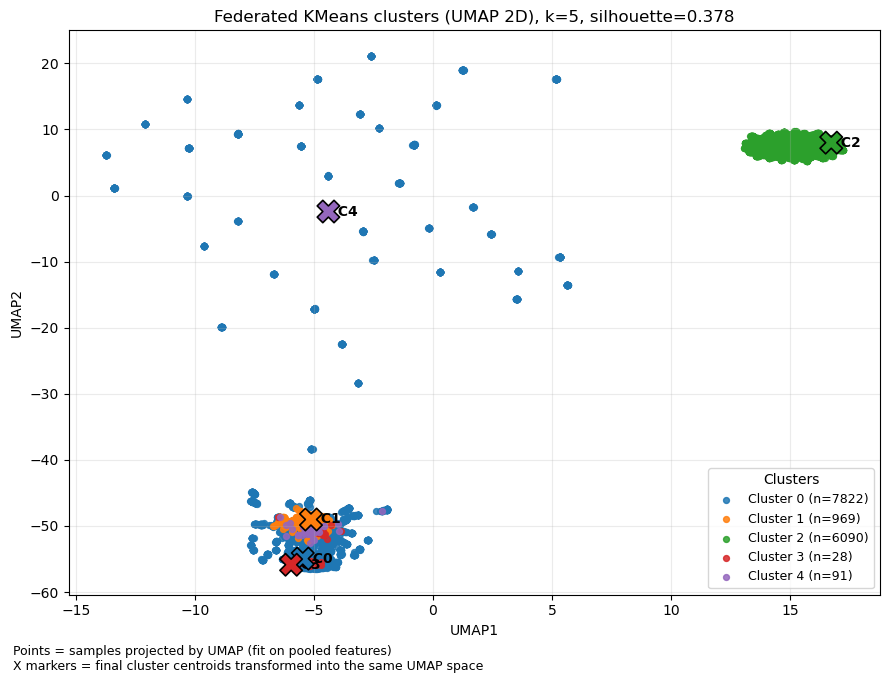

In [34]:
# UMAP plot with a simple legend (no colorbar) + richer annotations

import umap.umap_ as umap

k = Cs.shape[0]

# Cluster sizes (compute if you don't already have it)
sizes = pd.Series(labels).value_counts().sort_index()

# Fit UMAP on points, then transform centroids into same 2D space
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=0,
)
Z = reducer.fit_transform(Xs)
C2 = reducer.transform(Cs)

# Make a discrete palette from a matplotlib colormap
cmap = plt.get_cmap("tab10" if k <= 10 else "tab20")
colors = [cmap(i % cmap.N) for i in range(k)]

plt.figure(figsize=(9, 7))

# Plot each cluster separately so we can have a clean legend
for c in range(k):
    idx = (labels == c)
    if idx.sum() == 0:
        continue
    plt.scatter(
        Z[idx, 0], Z[idx, 1],
        s=18, alpha=0.85,
        color=colors[c],
        label=f"Cluster {c} (n={idx.sum()})"
    )

# Plot centroids
plt.scatter(
    C2[:, 0], C2[:, 1],
    s=260, marker="X",
    c=[colors[c] for c in range(k)],
    edgecolors="black",
    linewidths=1.2,
    zorder=5
)

# Annotate centroid labels next to the X markers
for c in range(k):
    plt.text(
        C2[c, 0], C2[c, 1],
        f"  C{c}",
        fontsize=10,
        weight="bold",
        va="center"
    )

# Title + description
title = f"Federated KMeans clusters (UMAP 2D), k={k}"
if "sil" in globals() and sil is not None:
    title += f", silhouette={sil:.3f}"
plt.title(title)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True, alpha=0.25)

desc = (
    "Points = samples projected by UMAP (fit on pooled features)\n"
    "X markers = final cluster centroids transformed into the same UMAP space\n"
)
plt.figtext(0.02, 0.01, desc, ha="left", va="bottom", fontsize=9)

plt.legend(
    title="Clusters",
    loc="lower right",
    frameon=True,
    fontsize=9,
    title_fontsize=10,
    ncol=1
)

plt.tight_layout(rect=[0, 0.06, 1, 1])  # leave room for figtext
plt.show()


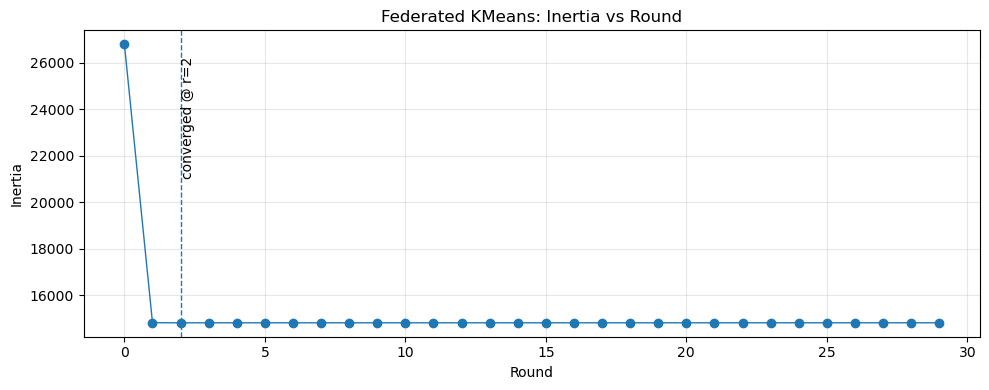

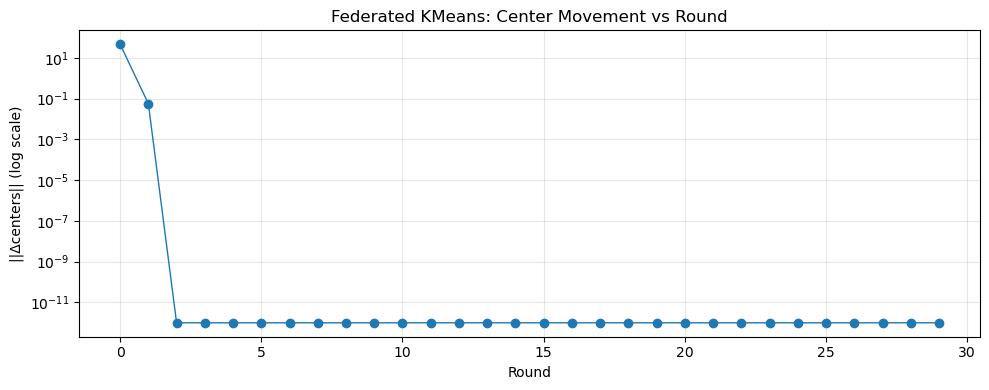

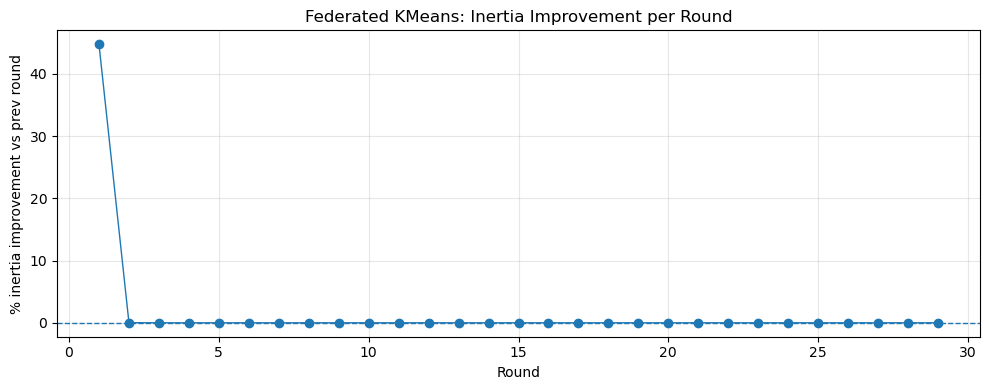

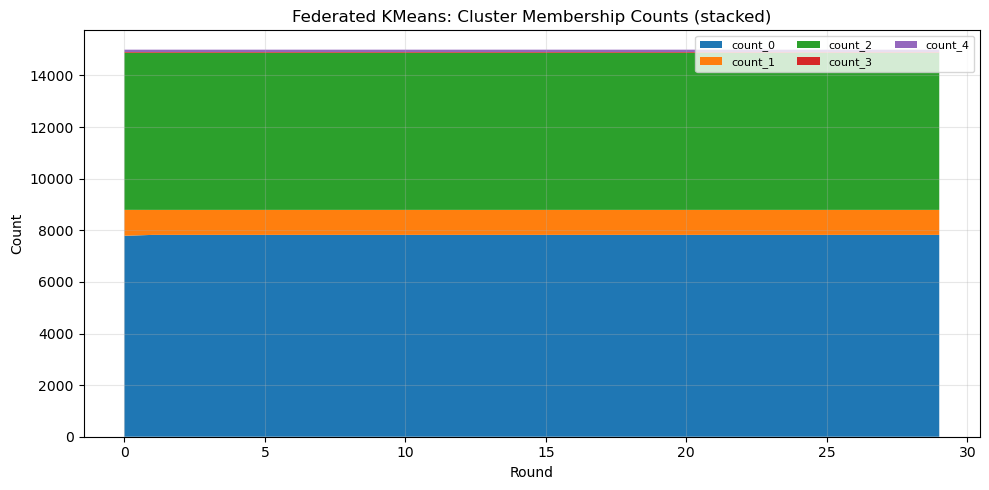

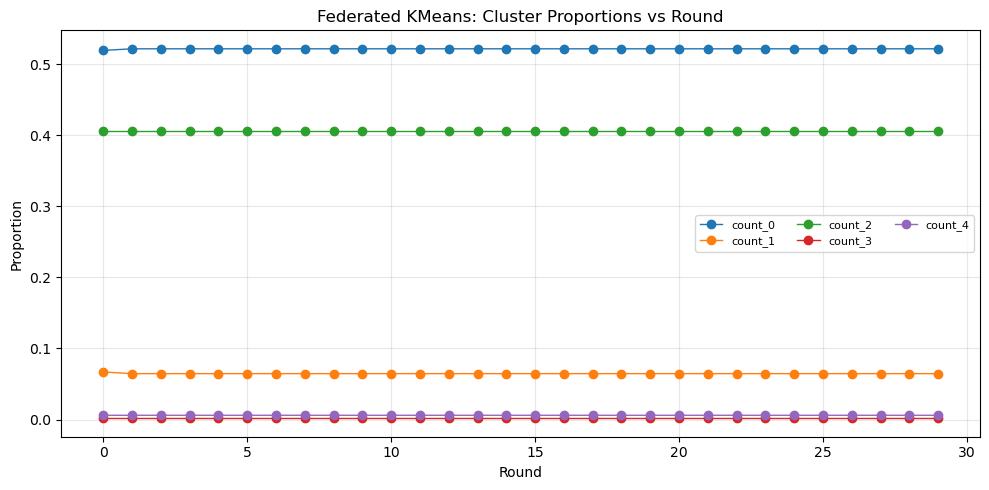

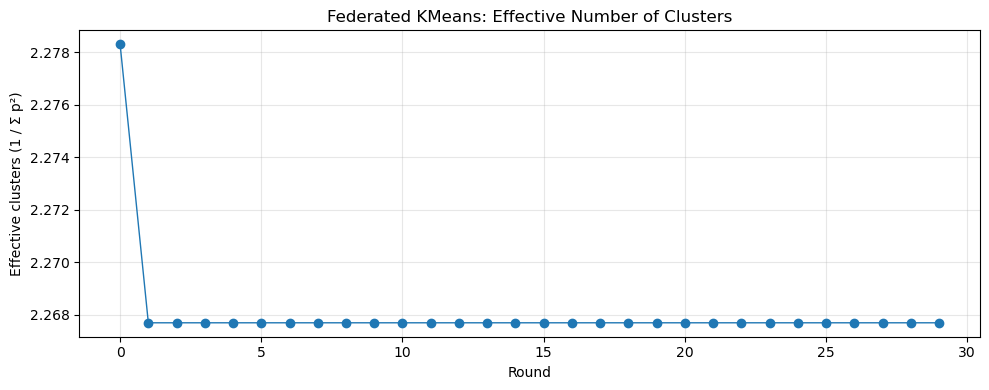

Converged round: 2
Final inertia: 14810.126953125
Final counts: {'count_0': 7822, 'count_1': 969, 'count_2': 6090, 'count_3': 28, 'count_4': 91}
Dead clusters: []
Tiny clusters: ['count_3']


In [30]:
csv_path = glob.glob("output_nvflare_kmeans/**/kmeans_metrics.csv", recursive=True)
m = pd.read_csv(csv_path[-1]).sort_values("round").reset_index(drop=True)

rounds = m["round"].to_numpy()
inertia = m["inertia"].to_numpy()
moved = m["moved"].to_numpy()

count_cols = [c for c in m.columns if c.startswith("count_")]
counts = m[count_cols].to_numpy()
total = counts.sum(axis=1)
props = counts / total[:, None]

# find convergence round: first round where moved == 0 and stays 0
conv_r = None
for i in range(len(rounds)):
    if moved[i] == 0 and np.all(moved[i:] == 0):
        conv_r = int(rounds[i])
        break

# 1) Inertia with improvement annotations
plt.figure(figsize=(10,4))
plt.plot(rounds, inertia, marker="o", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Inertia")
plt.title("Federated KMeans: Inertia vs Round")
if conv_r is not None:
    plt.axvline(conv_r, linestyle="--", linewidth=1)
    plt.text(conv_r, inertia.max()*0.98, f"converged @ r={conv_r}", rotation=90, va="top")
plt.tight_layout()
plt.show()

# 2) Movement (log scale helps when it quickly goes to 0)
eps = 1e-12
plt.figure(figsize=(10,4))
plt.plot(rounds, moved + eps, marker="o", linewidth=1)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("||Δcenters|| (log scale)")
plt.title("Federated KMeans: Center Movement vs Round")
plt.tight_layout()
plt.show()

# 3) Percent improvement in inertia per round
din = np.r_[np.nan, np.diff(inertia)]
pct = np.r_[np.nan, 100.0 * (inertia[:-1] - inertia[1:]) / np.maximum(inertia[:-1], 1e-12)]
plt.figure(figsize=(10,4))
plt.plot(rounds, pct, marker="o", linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("% inertia improvement vs prev round")
plt.title("Federated KMeans: Inertia Improvement per Round")
plt.tight_layout()
plt.show()

# 4) Cluster counts as stacked area (shows dominance + dead clusters)
plt.figure(figsize=(10,5))
plt.stackplot(rounds, counts.T, labels=count_cols)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Count")
plt.title("Federated KMeans: Cluster Membership Counts (stacked)")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# 5) Cluster proportions (lines)
plt.figure(figsize=(10,5))
for j, c in enumerate(count_cols):
    plt.plot(rounds, props[:, j], marker="o", linewidth=1, label=c)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Proportion")
plt.title("Federated KMeans: Cluster Proportions vs Round")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# 6) Effective number of clusters (1 / sum p^2), a nice “diversity” metric
eff_k = 1.0 / np.sum(props**2, axis=1)
plt.figure(figsize=(10,4))
plt.plot(rounds, eff_k, marker="o", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Effective clusters (1 / Σ p²)")
plt.title("Federated KMeans: Effective Number of Clusters")
plt.tight_layout()
plt.show()

# summary
final_counts = dict(zip(count_cols, counts[-1].tolist()))
dead = [c for c, v in final_counts.items() if v == 0]
tiny = [c for c, v in final_counts.items() if 0 < v <= 50]

print("Converged round:", conv_r)
print("Final inertia:", float(inertia[-1]))
print("Final counts:", final_counts)
print("Dead clusters:", dead)
print("Tiny clusters:", tiny)